# **Assignment 6 PART B - using Pytorch**

### Arpitha Gurumurthy

In this notebook:
* Loading and preprocessing the google image dataset of flowers
* Training an image classifier on our dataset
* Using the trained classifier to predict image content

## **Data Collection**
Downloading the dataset from images.google.com to create a custom dataset. Creating a dataset of flowers - roses, dandelions and lilies.

A multiclass classification with 3 target values.

Loading the images onto the drive and mounting it to use it in our colab.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
from fastai.vision import *

In [3]:
%cd /content/gdrive/My Drive/258_HW6

/content/gdrive/My Drive/258_HW6


In [4]:
##Importing the necessary libraries
import matplotlib.pyplot as plt

import json
import os
import torch
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from collections import OrderedDict
from PIL import Image
from torch import Tensor

import helper
from importlib import reload
reload(helper)

<module 'helper' (namespace)>

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
device

device(type='cuda', index=0)

In [7]:
rm -rf `find -type d -name .ipynb_checkpoints`

## **Splitting the dataset**

In [ ]:
# # Creating Train / Val / Test folders (One time use)
import os
import numpy as np
import shutil
import random
root_dir = '/content/gdrive/My Drive/258_HW6/roses/' # data root path
# classes_dir = ['good', 'bad'] #total labels

val_ratio = 0.15
test_ratio = 0.05


os.makedirs(root_dir +'train/')
os.makedirs(root_dir +'val/')
os.makedirs(root_dir +'test/')


# Creating partitions of the data after shuffeling
src = root_dir # Folder to copy images from

allFileNames = os.listdir(src)
np.random.shuffle(allFileNames)
train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), 
                                                           int(len(allFileNames)* (1 - test_ratio))])


train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

print('Total images: ', len(allFileNames))
print('Training: ', len(train_FileNames))
print('Validation: ', len(val_FileNames))
print('Testing: ', len(test_FileNames))

# Copy-pasting images
for name in train_FileNames:
    shutil.copy(name, root_dir +'train/')

for name in val_FileNames:
    shutil.copy(name, root_dir +'val/')

for name in test_FileNames:
    shutil.copy(name, root_dir +'test/')

## **Loading the data**
Using torchvision to load the data.

For the training, we are applying transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. Input data is resized to 224x224 pixels as required by the pre-trained networks.

The pre-trained networks we are using were trained on the ImageNet dataset where each color channel was normalized separately.

In [8]:
data_dir = '/content/gdrive/My Drive/258_HW6'
train_dir = data_dir
valid_dir = '/content/gdrive/My Drive/258_HW6_Validation'

In [ ]:
# !cp -rf '/content/gdrive/My Drive/258_HW6/roses' '/content/gdrive/My Drive/258_HW6/258_HW6_Validation'

In [ ]:
# !cp -rf '/content/gdrive/My Drive/258_HW6/dandelions' '/content/gdrive/My Drive/258_HW6/258_HW6_Validation'

In [ ]:
# !cp -rf '/content/gdrive/My Drive/258_HW6/lilies' '/content/gdrive/My Drive/258_HW6/258_HW6_Validation'

In [9]:
# Define transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(size=224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

validation_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the datasets with ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
validation_dataset = datasets.ImageFolder(valid_dir, transform=validation_transforms)

# Using the image datasets and the transforms, define the dataloaders
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=4)
valid_dataloader = DataLoader(validation_dataset, shuffle=True, batch_size=64, num_workers=4)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


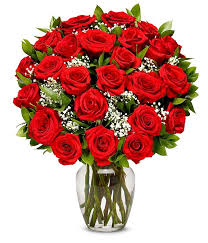

In [ ]:
from IPython.display import Image
Image('roses/00000049.jpg')

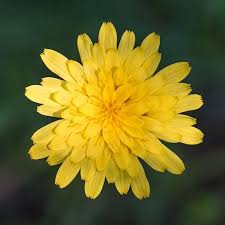

In [ ]:
from IPython.display import Image
Image('dandelions/00000055.jpg')

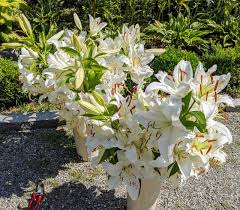

In [ ]:
from IPython.display import Image
Image('lilies/00000055.jpg')

## **Label mapping**
We are loading a mapping from category label to category name - 'Flower_Labels.json'. 

It's a JSON object which we are reading in with the json module. This will give us a dictionary mapping of the integer encoded categories to the names of the flowers - roses, dandelions and lilies.



In [10]:
with open("/content/gdrive/My Drive/258_HW6/Flower_Labels.json", 'r') as f:
    flower_Labels = json.load(f)

In [11]:
category_map = sorted(flower_Labels.items(), key=lambda x: int(x[0]))

In [12]:
category_names = [cat[1] for cat in category_map]

## **Count of flowers in each category**

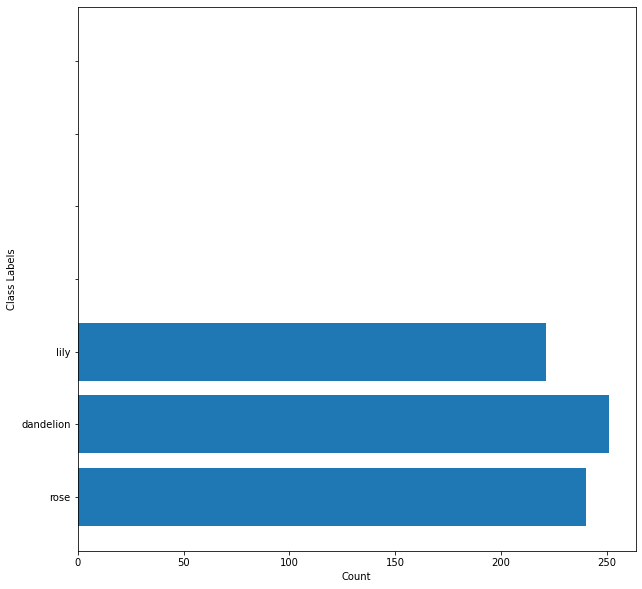

In [17]:
len(os.listdir(os.path.join("/content/gdrive/My Drive/", "258_HW6/")))

count = [len(os.listdir(os.path.join("/content/gdrive/My Drive/", "258_HW6/", dir))) for dir in os.listdir(os.path.join("/content/gdrive/My Drive/", "258_HW6/"))]
scalars = [*range(len(os.listdir(os.path.join("/content/gdrive/My Drive/", "258_HW6/"))))]
scalars = [x.__add__(1) for x in scalars]
plt.figure(figsize=(10,10))
plt.barh(scalars, count)
plt.yticks(scalars, category_names)
plt.xlabel("Count")
plt.ylabel("Class Labels")
plt.show()

## **Building and training the classifier**
Using pretrained model - VGG16 from torchvision.models to get the image features.

In [13]:
vgg16 = models.vgg16(pretrained=True)

In [14]:
##Architecture of the neural network
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:
# Freeze parameters so we don't backprop through them
for param in vgg16.parameters():
    param.requires_grad = False

classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 4096)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(p=0.5)),
                          ('fc2', nn.Linear(4096, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
vgg16.classifier = classifier
vgg16.class_idx_mapping = train_dataset.class_to_idx

In [16]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.0001)

In [17]:
def validation(model, testloader, criterion, device):
    test_loss = 0
    accuracy = 0
    model.to(device)
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        # images.resize_(images.shape[0], 3, 224, 224)

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy


In [18]:
def train(model, trainloader, validloader, epochs, print_every, criterion, optimizer, device='cuda'):
    steps = 0
    
    # Change to train mode if not already
    model.train()
    # change to cuda
    model.to(device)

    for e in range(epochs):
        running_loss = 0

        for (images, labels) in trainloader:
            steps += 1

            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward and backward passes
            outputs = model.forward(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if steps % print_every == 0:
                
                # Make sure network is in eval mode for inference
                model.eval()

                # Turn off gradients for validation, saves memory and computations
                with torch.no_grad():
                    validation_loss, accuracy = validation(model, validloader, criterion, device)

                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      "Validation Loss: {:.3f}.. ".format(validation_loss/len(validloader)),
                      "Validation Accuracy: {:.3f}".format((accuracy/len(validloader))*100))

                model.train()
                
                running_loss = 0

In [27]:
train(model=vgg16, 
        trainloader=train_dataloader, 
        validloader=valid_dataloader,
        epochs=1, 
        print_every=1, 
        criterion=criterion,
        optimizer=optimizer,
        device="cuda"
      )

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1/3..  Training Loss: 0.298..  Validation Loss: 8.212..  Validation Accuracy: 1.042
Epoch: 1/3..  Training Loss: 0.490..  Validation Loss: 8.354..  Validation Accuracy: 1.042
Epoch: 1/3..  Training Loss: 0.385..  Validation Loss: 8.635..  Validation Accuracy: 1.042
Epoch: 1/3..  Training Loss: 0.640..  Validation Loss: 8.512..  Validation Accuracy: 1.042
Epoch: 1/3..  Training Loss: 0.480..  Validation Loss: 8.496..  Validation Accuracy: 0.521


FileNotFoundError: ignored

In [20]:
!rm '/content/gdrive/My Drive/258_HW6/258_HW6_Validation/roses/00000126.jpg'

## **References:**
* https://github.com/nirajpandkar/flowers-classification-pytorch/blob/master/Image%20Classifier%20Project.ipynb
